In [162]:
from paths import DATA_DIR, CKPT_FOLDER, PROJECT_FOLDER

import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import anndata
import scanpy as sc
import sklearn
import scvelo as scv

import anndata
import pandas as pd

from IPython.display import display
from torchdyn.core import NeuralODE

from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.models.base.geodesic_ae import GeodesicAE

from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.cfm.components.eval.distribution_distances import compute_distribution_distances

from notebooks.utils import decode_trajectory_single_step, standardize, compute_prdc

Initialize the device

In [163]:
device = "cuda" if torch.cuda.is_available() else "cpu"

Initialize datamodule

In [164]:
datamodule={'path': PROJECT_FOLDER / 'data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'leiden'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 512, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

Initialize autoencoders

In [165]:
vae_kwargs={'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric_kwargs={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

geodesic_kwargs={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 10],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

# Initialize vae and geometric vae
vae = GeometricNBVAE(**geometric_kwargs, vae_kwargs=vae_kwargs).to(device)
geometric_vae = GeometricNBVAE(**geometric_kwargs, vae_kwargs=vae_kwargs).to(device)
geodesic_ae = GeodesicAE(**geodesic_kwargs).to(device)

# Load state dicts and put in eval mode 
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geometric_lib.ckpt")["state_dict"])
# geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geodesic_ae.ckpt")["state_dict"])

vae.eval()
geometric_vae.eval()
# geodesic_ae.eval()

GeometricNBVAE(
  (encoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1241, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (decoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (library_size_decoder): Linear(in_features=10, out_features=1, bias=True)
  (decoder_mu_lib): Linear(in_features=256, out_features=1241, bias=True)
  (mu_logvar): Linear(in_features=256, out_features=20, bias=True)
)

## Setup CFMs

In [166]:
leavout_timepoints_folder = CKPT_FOLDER / "trajectory" / "eb"

Initialize datamodule for trajectory

In [167]:
datamodule_kwargs_vae = {'path': PROJECT_FOLDER / 'data/eb/flat/eb_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                          'model_library_size': True}

datamodule_kwargs_flat = {'path': PROJECT_FOLDER / 'data/eb/flat/eb_flat_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

datamodule_kwargs_geodesic= {'path': PROJECT_FOLDER / 'data/eb/flat/eb_geodesic.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

# Initialize the datamodules 
datamodule_vae = TrajectoryDataModule(**datamodule_kwargs_vae)
datamodule_flat = TrajectoryDataModule(**datamodule_kwargs_flat)
# datamodule_geodesic = TrajectoryDataModule(**datamodule_kwargs_geodesic)

# Mapping real times to index
idx2time = datamodule_vae.idx2time

## Read data

First, read the latent space anndata and plot the results

In [168]:
# Read latent anndata
adata_latent_vae = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_lib.h5ad")
adata_latent_flat = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad")
# adata_latent_geodesic = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_geodesic.h5ad")

# Read real anndata
adata_eb_original = sc.read_h5ad(PROJECT_FOLDER / 'data/eb/processed/eb_phate.h5ad')
sc.tl.pca(adata_eb_original, n_comps=50)
adata_eb_original.X = adata_eb_original.layers["X_norm"].copy()

Number of experiments 

In [169]:
n_timepoints = len(np.unique(adata_latent_vae.obs.experimental_time))
idx2time = dict(zip(range(n_timepoints), np.unique(adata_latent_vae.obs.experimental_time)))
idx2time

{0: 0.0, 1: 0.25, 2: 0.5, 3: 0.75, 4: 1.0}

Initialize model

In [170]:
net_hparams = {"dim": adata_latent_flat.X.shape[1]+1,
                "w": 64,
                "time_varying": True}

cfm_kwargs = {'ot_sampler': 'exact', 
                   'sigma': 0.1, 
                   'use_real_time': False, 
                   'lr': 0.001, 
                   'antithetic_time_sampling': True}

## Evaluation

Load checkpoints

In [171]:
leaveput_ckpt_vae = {}
leaveout_ckpt_flat = {}
leaveout_ckpt_geodesic = {}

Time point 1
predict latent trajectory
(['1-Wasserstein', '2-Wasserstein', 'Linear_MMD', 'Poly_MMD', 'RBF_MMD', 'Mean_MSE', 'Mean_L2', 'Mean_L1', 'Median_MSE', 'Median_L2', 'Median_L1'], [2.187590044591304, 2.2769183708219565, 0.09418192505836487, 0.3068907379807427, 0.24797384440898895, 0.1138848289847374, 0.33746826367043375, 0.2708362936973572])
(['1-Wasserstein', '2-Wasserstein', 'Linear_MMD', 'Poly_MMD', 'RBF_MMD', 'Mean_MSE', 'Mean_L2', 'Mean_L1', 'Median_MSE', 'Median_L2', 'Median_L1'], [2.8163539335474908, 3.0852722469022984, 0.4147643446922302, 0.6440220063726319, 0.4802493453025818, 0.4302690923213959, 0.6559490013113793, 0.5124536752700806])


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


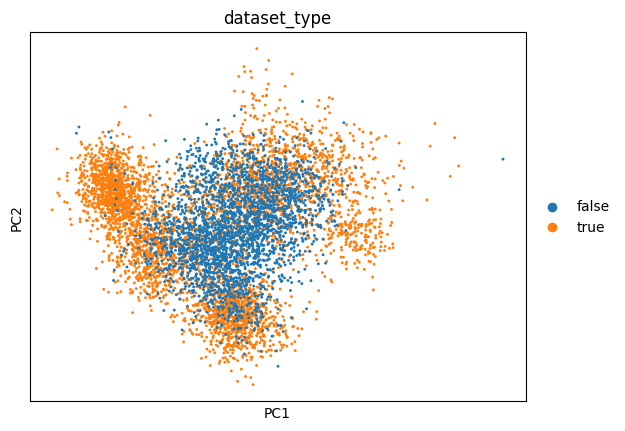

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


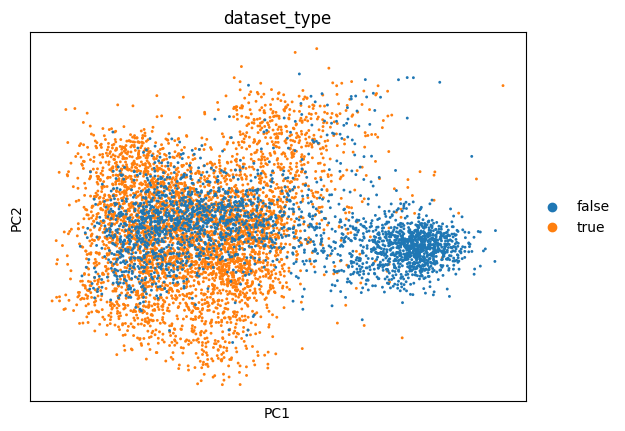

Time point 2
predict latent trajectory
(['1-Wasserstein', '2-Wasserstein', 'Linear_MMD', 'Poly_MMD', 'RBF_MMD', 'Mean_MSE', 'Mean_L2', 'Mean_L1', 'Median_MSE', 'Median_L2', 'Median_L1'], [1.8432022838688675, 1.951720999186642, 0.05864528939127922, 0.2421678950465549, 0.21004493534564972, 0.058481376618146896, 0.24182923028068154, 0.21579667925834656])
(['1-Wasserstein', '2-Wasserstein', 'Linear_MMD', 'Poly_MMD', 'RBF_MMD', 'Mean_MSE', 'Mean_L2', 'Mean_L1', 'Median_MSE', 'Median_L2', 'Median_L1'], [1.5528056143157842, 1.7613299137624538, 0.08371564000844955, 0.2893365514559983, 0.26032018661499023, 0.06218251585960388, 0.24936422329517097, 0.20445683598518372])


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


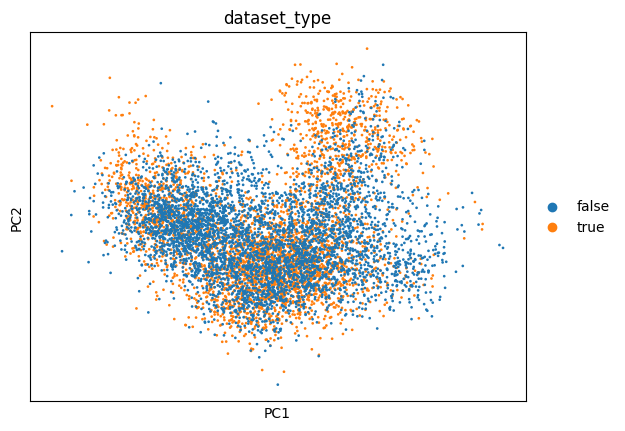

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


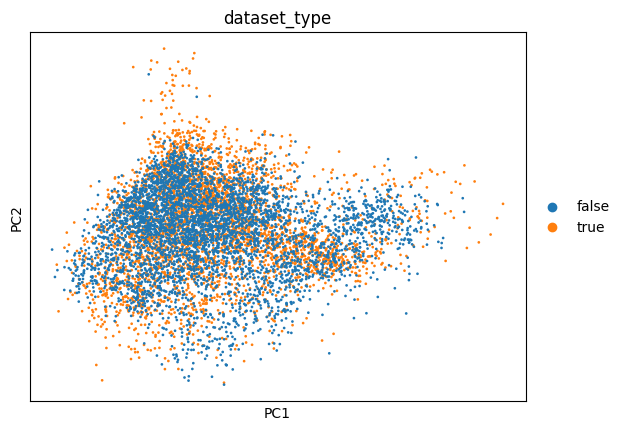

Time point 3
predict latent trajectory
(['1-Wasserstein', '2-Wasserstein', 'Linear_MMD', 'Poly_MMD', 'RBF_MMD', 'Mean_MSE', 'Mean_L2', 'Mean_L1', 'Median_MSE', 'Median_L2', 'Median_L1'], [1.8110364010997766, 1.9331939327404115, 0.0821307897567749, 0.28658469909744816, 0.21728917956352234, 0.07367168366909027, 0.2714252819268873, 0.20719239115715027])
(['1-Wasserstein', '2-Wasserstein', 'Linear_MMD', 'Poly_MMD', 'RBF_MMD', 'Mean_MSE', 'Mean_L2', 'Mean_L1', 'Median_MSE', 'Median_L2', 'Median_L1'], [1.3395290235939934, 1.4201501173444546, 0.0722242146730423, 0.26874563191434814, 0.2082778960466385, 0.0837135910987854, 0.28933301073120815, 0.23473386466503143])


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


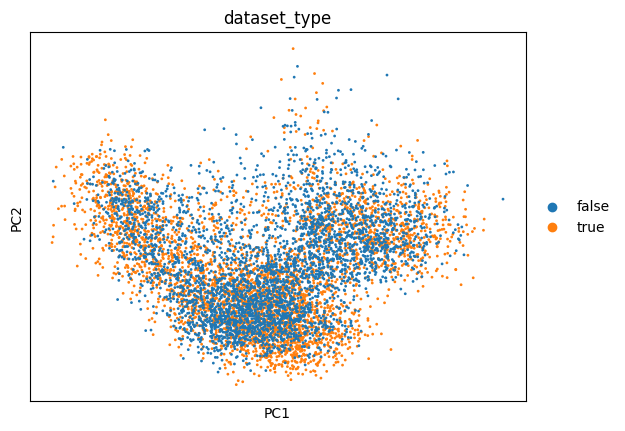

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


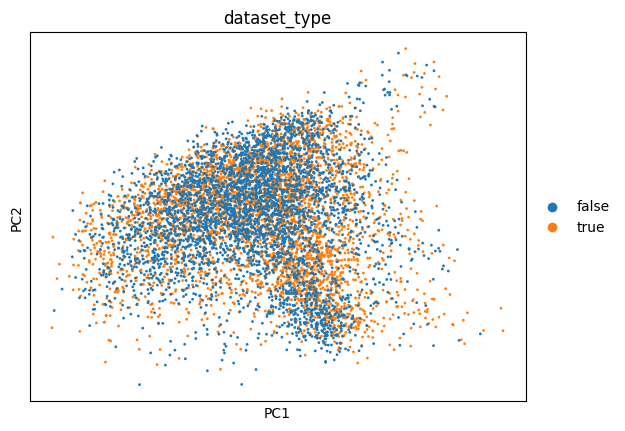

In [172]:
for tp in range(1, n_timepoints-1):
    print(f"Time point {tp}")
    #Pick time 0 observations
    X_adata_t0_latent_vae = torch.from_numpy(adata_latent_vae[adata_latent_vae.obs["experimental_time"]==idx2time[(tp-1)]].X).to(device)
    X_adata_t0_latent_flat = torch.from_numpy(adata_latent_flat[adata_latent_flat.obs["experimental_time"]==idx2time[(tp-1)]].X).to(device)
    # X_adata_t0_latent_geodesic = torch.from_numpy(adata_latent_geodesic[adata_latent_geodesic.obs["experimental_time"]==idx2time[(tp-1)]].X).to(device)

    # Pick observations next timepoint 
    X_adata_t1_latent_vae = torch.from_numpy(adata_latent_vae[adata_latent_vae.obs["experimental_time"]==idx2time[tp]].X).to(device)
    X_adata_t1_latent_flat = torch.from_numpy(adata_latent_flat[adata_latent_flat.obs["experimental_time"]==idx2time[tp]].X).to(device)
    # X_adata_t1_latent_geodesic = torch.from_numpy(adata_latent_geodesic[adata_latent_geodesic.obs["experimental_time"]==idx2time[tp]].X).to(device)    

    # Collect PCs    
    X_adata_real_pca = torch.from_numpy(adata_eb_original[adata_eb_original.obs["experimental_time"]==idx2time[tp]].obsm["X_pca"]).to(device)
    X_adata_real = torch.from_numpy(adata_eb_original[adata_eb_original.obs["experimental_time"]==idx2time[tp]].layers["X_log"].A).to(device)

    #Pick library sizes
    l_t0_vae = adata_latent_vae.obs.loc[adata_latent_vae.obs["experimental_time"]==idx2time[(tp-1)], "log_library_size"].to_numpy()
    l_t0_flat = adata_latent_flat.obs.loc[adata_latent_flat.obs["experimental_time"]==idx2time[(tp-1)], "log_library_size"].to_numpy()
    # l_t0_geodesic = adata_latent_geodesic.obs.loc[adata_latent_geodesic.obs["experimental_time"]==idx2time[(tp-1)], "log_library_size"].to_numpy()

    #Pick library sizes
    l_t0_vae = torch.from_numpy(l_t0_vae).to(device)
    l_t0_flat = torch.from_numpy(l_t0_flat).to(device)
    # l_t0_geodesic = torch.from_numpy(l_t0_geodesic).to(device)

    # Initialize nets
    net_vae = MLP(**net_hparams).to(device)
    net_flat = MLP(**net_hparams).to(device)
    # net_geodesic = MLP(**net_hparams).to(device)
    cfm_vae = CFMLitModule(net=net_vae, datamodule=datamodule_vae, **cfm_kwargs).to(device)
    cfm_flat = CFMLitModule(net=net_flat, datamodule=datamodule_flat, **cfm_kwargs).to(device)
    # cfm_geodesic = CFMLitModule(net=net_geodesic, datamodule=datamodule_geodesic, **cfm_kwargs).to(device)

    # Read the checkpoints
    cfm_vae.load_state_dict(torch.load(leavout_timepoints_folder / f"eb_vae_leaveout_{tp}.ckpt")["state_dict"])
    # cfm_flat.load_state_dict(torch.load(leavout_timepoints_folder / f"eb_flat_leaveout_{tp}.ckpt")["state_dict"])
    # cfm_geodesic.load_state_dict(torch.load(leavout_timepoints_folder / f"eb_geodesic_leaveout_{tp}.ckpt")["state_dict"])

    _, X_adata_predicted_vae, X_adata_latent_vae = decode_trajectory_single_step(X_adata_t0_latent_vae, 
                                                                                 l_t0_vae, 
                                                                                 tp-1, 
                                                                                 cfm_vae, 
                                                                                 vae)
                                                                                
    _, X_adata_predicted_flat, X_adata_latent_flat = decode_trajectory_single_step(X_adata_t0_latent_flat, 
                                                                                   l_t0_flat, 
                                                                                   tp-1, 
                                                                                   cfm_flat, 
                                                                                   geometric_vae)
                                                                                  
    # _, X_adata_predicted_geodesic, X_adata_latent_geodesic = decode_trajectory_single_step(X_adata_t0_latent_geodesic, 
    #                                                                                        l_t0_geodesic, 
    #                                                                                        tp-1, 
    #                                                                                        cfm_geodesic, 
    #                                                                                        geodesic_ae, 
    #                                                                                        model_type="geodesic_ae")

    print("predict latent trajectory")
    X_adata_t1_latent_vae, X_adata_latent_vae = cross_standardize(X_adata_t1_latent_vae, X_adata_latent_vae[:,:-1])
    X_adata_t1_latent_flat, X_adata_latent_flat = cross_standardize(X_adata_t1_latent_flat, X_adata_latent_flat[:,:-1])
                                                                                   
    print(compute_distribution_distances(X_adata_t1_latent_vae.unsqueeze(1).to("cpu"), 
                                         X_adata_latent_vae.unsqueeze(1).to("cpu")))
    print(compute_distribution_distances(X_adata_t1_latent_flat.unsqueeze(1).to("cpu"),
                                         X_adata_latent_flat.unsqueeze(1).to("cpu")))
    # print(compute_prdc(X_adata_t1_latent_vae.to("cpu"), X_adata_latent_vae.to("cpu"), nearest_k=5))
    # print(compute_prdc(X_adata_t1_latent_flat.to("cpu"), X_adata_latent_flat.to("cpu"), nearest_k=5))
    # print(compute_prdc(X_adata_t1_latent_vae.to("cpu"), torch.randn_like(X_adata_latent_vae.to("cpu")), nearest_k=5))
    # print(compute_prdc(X_adata_t1_latent_flat.to("cpu"), torch.randn_like(X_adata_latent_flat.to("cpu")), nearest_k=5))

    fake_adata_vae_z = anndata.AnnData(X=X_adata_latent_vae.cpu().numpy())
    fake_adata_flat_z = anndata.AnnData(X=X_adata_latent_flat.cpu().numpy())
    real_adata_vae_z = anndata.AnnData(X=X_adata_t1_latent_vae.cpu().numpy())
    real_adata_flat_z = anndata.AnnData(X=X_adata_t1_latent_flat.cpu().numpy())
    adata_vae = anndata.concat([real_adata_vae_z, fake_adata_vae_z])
    adata_vae.obs = pd.DataFrame(["true" for _ in range(len(real_adata_vae_z))] + ["false" for _ in range(len(fake_adata_vae_z))])
    adata_vae.obs.columns = ["dataset_type"]
    adata_flat = anndata.concat([real_adata_flat_z, fake_adata_flat_z])
    adata_flat.obs = pd.DataFrame(["true" for _ in range(len(real_adata_flat_z))] + ["false" for _ in range(len(fake_adata_flat_z))])
    adata_flat.obs.columns = ["dataset_type"]
    
    sc.tl.pca(adata_vae)
    sc.tl.pca(adata_flat)
    sc.pl.pca(adata_vae, color="dataset_type")
    sc.pl.pca(adata_flat, color="dataset_type")

    # print(compute_distribution_distances(standardize(X_adata_t1_latent_vae).unsqueeze(1).to("cpu"), 
    #                                      standardize(X_adata_latent_vae[:,:-1]).unsqueeze(1).to("cpu")))
    # print(compute_distribution_distances(standardize(X_adata_t1_latent_flat).unsqueeze(1).to("cpu"),
    #                                      standardize(X_adata_latent_flat[:,:-1]).unsqueeze(1).to("cpu")))
    # print(compute_distribution_distances(standardize(X_adata_t1_latent_geodesic).unsqueeze(1).to("cpu"),
    #                                      standardize(X_adata_latent_geodesic[:,:-1]).unsqueeze(1).to("cpu")))


    # print("predict decoded trajectory")
    # X_adata_predicted_vae = anndata.AnnData(X=X_adata_predicted_vae.numpy())
    # X_adata_predicted_flat = anndata.AnnData(X=X_adata_predicted_flat.numpy())
    # X_adata_predicted_geodesic = anndata.AnnData(X=X_adata_predicted_geodesic.numpy())
    # sc.pp.log1p(X_adata_predicted_vae)
    # sc.pp.log1p(X_adata_predicted_flat)
    # sc.tl.pca(X_adata_predicted_vae, n_comps=50)
    # sc.tl.pca(X_adata_predicted_flat, n_comps=50)
    # sc.tl.pca(X_adata_predicted_geodesic, n_comps=50)

    # print(compute_prdc(torch.from_numpy(X_adata_predicted_vae.obsm["X_pca"]), 
    #                                          X_adata_real_pca.to("cpu"), nearest_k=30))
    # print(compute_prdc(torch.from_numpy(X_adata_predicted_flat.obsm["X_pca"]), 
    #                                          X_adata_real_pca.to("cpu"), nearest_k=30))
    # print(compute_prdc(torch.from_numpy(X_adata_predicted_geodesic.obsm["X_pca"]), 
    #                                          X_adata_real_pca.to("cpu"), nearest_k=30))
    # print()

In [173]:
display(pd.DataFrame(compute_distribution_distances(X_adata_t1_latent_flat.unsqueeze(1).to("cpu"),
                                         X_adata_latent_flat.unsqueeze(1).to("cpu"))))

,0,1,2,3,4,5,6,7,8,9,10
0,1-Wasserstein,2-Wasserstein,Linear_MMD,Poly_MMD,RBF_MMD,Mean_MSE,Mean_L2,Mean_L1,Median_MSE,Median_L2,Median_L1
1,1.339529,1.42015,0.072224,0.268746,0.208278,0.083714,0.289333,0.234734,None,None,None


In [174]:
display(pd.DataFrame(compute_distribution_distances(X_adata_t1_latent_vae.unsqueeze(1).to("cpu"),
                                         X_adata_latent_vae.unsqueeze(1).to("cpu"))))

,0,1,2,3,4,5,6,7,8,9,10
0,1-Wasserstein,2-Wasserstein,Linear_MMD,Poly_MMD,RBF_MMD,Mean_MSE,Mean_L2,Mean_L1,Median_MSE,Median_L2,Median_L1
1,1.811036,1.933194,0.082131,0.286585,0.217289,0.073672,0.271425,0.207192,None,None,None


In [175]:
def cross_standardize(tensor1, tensor2):
    """
    Standardize tensor across the rows
    """
    mean_t1, std_t1 = tensor1.mean(0), tensor1.std(0)
    tensor1 = (tensor1 - mean_t1) / (std_t1 + 1e-6)
    tensor2 = (tensor2 - mean_t1) / (std_t1 + 1e-6)
    return tensor1, tensor2

In [176]:
f = "/home/icb/alessandro.palma/environment/scCFM/scCFM/train_hydra/multirun/2023-09-23/17-38-14/.submitit/13690774_0/13690774_0_submitted.pkl"

In [177]:
import pickle as pkl
with open(f, "rb") as file:
    f = pkl.load(file)

In [178]:
f.__dict__

{'function': <hydra_plugins.hydra_submitit_launcher.submitit_launcher.SlurmLauncher at 0x7feec55c3e80>,
 'args': (['model.leaveout_timepoint=2',
   'hydra=CFM_schiebinger_leaveout',
   'datamodule=CFM_schiebinger_leaveout',
   'logger=CFM_schiebinger_leaveout',
   'train=CFM_schiebinger_leaveout'],
  'hydra.sweep.dir',
  0,
  'job_id_for_0',
  {'instances': {hydra.core.config_store.ConfigStore: <hydra.core.config_store.ConfigStore at 0x7feec5376200>,
    hydra.version.VersionBase: <hydra.version.VersionBase at 0x7feec563d510>,
    hydra._internal.sources_registry.SourcesRegistry: <hydra._internal.sources_registry.SourcesRegistry at 0x7feec563d630>,
    hydra.core.utils.JobRuntime: <hydra.core.utils.JobRuntime at 0x7feec563d690>,
    hydra.core.global_hydra.GlobalHydra: <hydra.core.global_hydra.GlobalHydra at 0x7feec563d7b0>},
   'omegaconf_resolvers': {'oc.create': <function omegaconf.omegaconf.OmegaConf.register_new_resolver.<locals>.resolver_wrapper(config: omegaconf.basecontainer.Ba